# 회귀 모델 학습 (y: 사용전력량)
## 실험7) 직전 'C-inj' 사용 방식에서 다양한 모델, 전처리, 변수 적용 등으로 최대 성능 확보
## 실험7-5) 최고 성능 LR 모델

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import requests
import os
import random
import warnings
# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [194]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [195]:
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

In [196]:
def set_all_seeds(seed):
    """
    Sets the random seeds for Python, NumPy, and optionally TensorFlow and PyTorch
    to ensure reproducibility.
    """
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed)
    
    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed)

In [197]:
SEED_VALUE = 42
set_all_seeds(SEED_VALUE)

In [198]:
def scatter_plot_r2(data, col_name_1, col_name_2):
    # --- Data Preparation ---
    # Ensure the analysis runs without errors by removing any rows with missing data (NaN)
    # in the relevant columns.
    valid_data = data[[col_name_1, col_name_2]].dropna()
    x = valid_data[col_name_1]
    y = valid_data[col_name_2]

    # --- Linear Regression Analysis ---
    # Perform the linear regression to find the best-fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Calculate R-squared, which measures how well the x-variable predicts the y-variable
    r_squared = r_value**2

    # --- Visualization ---
    # Create the figure and scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, s=5, alpha=0.6, label='Actual Data')

    # Plot the regression line using the calculated slope and intercept
    line = slope * x + intercept
    plt.plot(x, line, color='red', label='Regression Line')

    # --- Final Touches ---
    # Add labels, a title, and a grid for better readability
    plt.xlabel(col_name_1)
    plt.ylabel(col_name_2)
    plt.title(f'\'{col_name_2}\' vs. \'{col_name_1}\'')
    plt.grid(True)

    # Display the R-squared value in a text box on the plot
    # The '$' signs render the text in a mathematical font
    plt.text(0.05, 0.95, f'$R^2 = {r_squared:.4f}$',
            transform=plt.gca().transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    # Show the legend to identify the data points and the line
    plt.legend()

    # Display the final plot
    plt.show()

def scatter_plot_metric(y_true, y_pred, metrics):
    metric_values = {
        'mae': None,
        'rmse': None,
        'r2': None,
        'mape': None,
        }
    if 'mae' in metrics:
        metric_values['mae'] = mean_absolute_error(y_true, y_pred)
    if 'rmse' in metrics:
        metric_values['rmse'] = root_mean_squared_error(y_true, y_pred)
    if 'r2' in metrics:
        metric_values['r2'] = r2_score(y_true, y_pred)
    if 'mape' in metrics:
        metric_values['mape'] = mean_absolute_percentage_error(y_true, y_pred)

    # --- New code for plotting ---
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)

    # Add a line for perfect predictions (y=x)
    lims = [
        np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),
        np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),
    ]
    plt.plot(lims, lims, 'r--', alpha=0.75, label='Perfect Fit')

    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"True vs. Predicted Values")
    plt.grid(True)

    # --- Annotation Logic ---
    # 1. Create a list of formatted strings for metrics that were calculated
    text_parts = []
    if metric_values['mae'] is not None:
        text_parts.append(f"MAE: {metric_values['mae']:.2f}")
    if metric_values['rmse'] is not None:
        text_parts.append(f"RMSE: {metric_values['rmse']:.2f}")
    if metric_values['r2'] is not None:
        text_parts.append(f"R²: {metric_values['r2']:.2f}") # Use a proper R-squared symbol
    if metric_values['mape'] is not None:
        text_parts.append(f"MAPE: {metric_values['mape']:.2f}%")

    # 2. If the list is not empty, join the parts into a single multi-line string
    if text_parts:
        annotation_text = "\n".join(text_parts)
        # 3. Plot the string on the graph
        plt.text(0.05, 0.95, annotation_text,
                 transform=plt.gca().transAxes,
                 fontsize=12,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

In [199]:
merged_df = pd.read_csv('C:/Users/User/kyushu_with_weather_with_restart_counter.csv', low_memory=False)
#merged_df = pd.read_csv('C:/Users/User/kyushu_with_weather_with_restart_counter_post_repair.csv', low_memory=False)
merged_df.shape

(2941, 392)

In [200]:
# 온도값이 NaN인 인스턴스 제거
merged_df.dropna(subset=['temp'], inplace=True)
merged_df.shape

if '사용전력량' in merged_df.columns:
    initial_count_oxygen = len(merged_df)
    merged_df = merged_df[merged_df['사용전력량'] >= 15000]
    removed_count_oxygen = initial_count_oxygen - len(merged_df)
    print(f"Removed {removed_count_oxygen} rows where {'사용전력량'} > 15000.")
else:
    print(f"Warning: '{'사용전력량'}' column not found.")

Removed 8 rows where 사용전력량 > 15000.


In [201]:
# 학습에 필요한 변수 리스트 선언
# Time index
time_col = [
    'time',
]

# 고철 종류별 장입량
scraps_col = [
    '스크랩_S01_친',
    #'스크랩_S01_자',
    # '스크랩_S01_손', # for GPR
    'A부스러기　친',
    #'A부스러기 자',
    #'A부스러기 손',
     '친단　친', # for GPR
    #'친단　자',
    #'친단　손',
    '와셔 친',
    # '와셔 자', # for GPR
    # '와셔 손', # for GPR
    'B부스러기　친',
    #'B부스러기 자',
    #'B부스러기 손',
    '선다라이 친',
    # '선다라이 자', # for GPR
    # '선다라이 손', # for GPR
     '류선 친', # for GPR
    #'류선 자',
    # '류선 손', # for GPR
    '시타마와리(자동차 부품으로 예상됨)　친',
    # '시타마와리(자동차 부품으로 예상됨)　자', # for GPR
    # '시타마와리(자동차 부품으로 예상됨)　손', # for GPR
    '엔진 친',
    # '엔진 자',
    # '엔진 손',
    '슈레더 친',
    #'슈레더 자',
    #'슈레더 손',
    'C프레스 친',
    #'C프레스 자',
    # 'C프레스 손', # for GPR
     '다라이가루 친', # for GPR
    #'다라이가루 자',
    #'다라이가루 손',
    '강류 친',
    # '강류 자', # for GPR
    # '강류 손', # for GPR
    '타이어 친',
    # '타이어　자', # for GPR
    # '타이어　손', # for GPR
    '주물　친',
    # '주물　자', # for GPR
    # '주물　손', # for GPR
     '알루미더스트　친', # for GPR
    # '알루미더스트　자', # for GPR
    # '알루미더스트　손', # for GPR
     'AB프레스　친', # for GPR
    # 'AB프레스　자', # for GPR
    # 'AB프레스　손', # for GPR
     'Mn강　친', # for GPR
    # 'Mn강　자', # for GPR
    # 'Mn강　손', # for GPR
     '캔버서　친', # for GPR
    # '캔버서　자', # for GPR
    # '캔버서　손', # for GPR
     '페인트캔　친', # for GPR
    # '페인트캔　자', # for GPR
    # '페인트캔　손', # for GPR
    'V프레스　친',
    # 'V프레스　자', # for GPR
    # 'V프레스　손', # for GPR
     '캔프레스　친', # for GPR
    #'캔프레스　자',
    # '캔프레스　손', # for GPR
    '빌렛부스러기　친',
    # '빌렛부스러기 자', # for GPR
    # '빌렛부스러기 손', # for GPR
     'SC（레들）바탕쇠　친', # for GPR
    #'SC（레들）바탕쇠　자',
    # 'SC（레들）바탕쇠　손', # for GPR
     'EF바탕쇠　친', # for GPR
    #'EF바탕쇠　자',
    # 'EF바탕쇠　손', # for GPR
     'CC바탕쇠　친', # for GPR
    # 'CC바탕쇠　자', # for GPR
    # 'CC바탕쇠　손', # for GPR
    '정비부스러기　친',
    # '정비부스러기　자', # for GPR
    # '정비부스러기　손', # for GPR
]

# 첨가제 종류별 장입량
additives_col = [
    # 'CaO',
    # 'CaO(ﾌﾚｺﾝ)',
    # 'FeSi75',
    # 'FeMn',
    # 'SiMn',
    # 'SiC',
    # 'CaSi',
    # 'FeSi70',
    'C-inj(佐山)',
    # '봉지포장카본ﾝ',
    # '무연탄',
    # '알루미늄 재(ﾌﾚ)',
    # '알루미늄 재(종이)',
    # '취부재',
    # '마그네시아',
    # '로상재',
    # '구C-inj',
    # 'FeNi',
    # 'FeMo',
    # 'FeCr',
    # 'FeV(50)',
    # 'SiMn0-20',
    # '재생카본',
    # '냉재',
    # 'SiMn1-3',
    # 'Fe-Mn1-3',
    # 'FeSi(P)',
    # '부자재_A28',
    # '부자재_A29',
    # '부자재_A30',
    ############
    '통전시간_합계',
]

extra_col = [
    '연회회수',
    #'restart_counter'
    #'누적장입생산차이t'
    ###############
    # '란스O2_로 보수/수리',
    # '란스O2_주요장입',
    # '란스O2_추가1',
    # '란스O2_추가2',
    # '란스O2_산화',
    # '란스O2_환원',
    # '버너O2_로 보수/수리',
    # '버너O2_주요장입',
    # '버너O2_추가1',
    # '버너O2_추가2',
    # '버너O2_산화',
    # '버너O2_환원',
    # '버너오일_로 보수/수리',
    # '버너오일_주요장입',
    # '버너오일_추가1',
    # '버너오일_추가2',
    # '버너오일_산화',
    # '버너오일_환원',
    # 'PSAO2_로 보수/수리',
    # 'PSAO2_주요장입',
    # 'PSAO2_추가1',
    # 'PSAO2_추가2',
    # 'PSAO2_산화',
    # 'PSAO2_환원',
    # 'LO2_로 보수/수리',
    # 'LO2_주요장입',
    # 'LO2_추가1',
    # 'LO2_추가2',
    # 'LO2_산화',
    # 'LO2_환원',
]

# 큐슈제강 조업 날씨
weather_col = [
    'temp', # 기온 (섭씨)
    'rhum', # 상대습도 (%)
    # 'prcp',
    # 'pres',
]

# 기타 (for feature engineering)
etc_col = [
    '강종명',
]

# 출력 변수
target_col = [
    '사용전력량'
]

In [202]:
# 학습에 필요한 변수만을 추출
selected_df = merged_df[time_col + scraps_col + additives_col + extra_col + weather_col + etc_col + target_col]
selected_df.fillna(0, inplace=True)
selected_df['time'] = pd.to_datetime(selected_df['time'])

C:\Users\User\AppData\Local\Temp\ipykernel_20088\2953839804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df.fillna(0, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_20088\2953839804.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['time'] = pd.to_datetime(selected_df['time'])


In [203]:
# Feature pipeline
# 훈련 데이터의 강종별 'C-inj(佐山)' 평균과 표준편차를 저장함.
# 이후 for 문을 돌면서 현재 샘플의 강종명을 저장해두고,
# 강종명이 일치하고, 정합성을 만족하는 이전 시점 샘플 탐색.
# 탐색에 성공한 경우 해당 샘플의 'C-inj(佐山)'을 불러와서 현재 샘플 값으로 사용함.
# 탐색에 실패한 경우 저장된 훈련 데이터의 강종별 평균을 사용함.
# 평균값도 없으면 해당 인스턴스의 'C-inj(佐山)'은 NaN 값으로 채움.

# 정합성 만족 기준은 평균 +- n 표준편차 이내

def feature_pipeline(df, additives_col, etc_col, train_df_for_stats=None, time_col='time', n_std=3, drop_na=True):
    """
    Performs feature engineering on a given dataframe.
    - If train_df_for_stats is provided (inference mode), it uses stats from that dataframe.
    - If not (training mode), it calculates stats from the input df itself.

    The logic is as follows:
    1. Calculate mean and std for each steel grade from the stats source.
    2. For each row in the target df, find the value from the previous heat of the same grade.
    3. If the previous value is valid (within n_std of the grade's mean), use it.
    4. If not, use the grade's average as a fallback.
    5. Drop rows with remaining NaNs if drop_na is True.
    """
    # Create a copy to avoid modifying the original DataFrame
    df_processed = df.copy()

    # --- 1. Determine the source for statistics and calculate them ---
    if train_df_for_stats is not None:
        # Inference mode: Use the provided training data to calculate stats
        stats_source_df = train_df_for_stats
        print("Running in INFERENCE mode: Using stats from provided train_df.")
    else:
        # Training mode: Use the input dataframe itself to calculate stats
        stats_source_df = df_processed
        print("Running in TRAINING mode: Using stats from the input df itself.")
        
    # Calculate stats for the validity check (mean and std from the stats source)
    grade_stats = stats_source_df.groupby('강종명')[additives_col].agg(['mean', 'std'])

    # --- 2. Apply feature engineering to the target dataset ---
    # Sort the target dataframe by time to correctly identify the previous heat
    df_processed.sort_values(by=time_col, inplace=True)

    # Loop through each additive column
    for col in additives_col:
        # Get the value from the previous heat of the same grade
        prev_values = df_processed.groupby('강종명')[col].shift(1)

        # Get the corresponding stats for each row's grade, using the stats from the source
        mean_values = df_processed['강종명'].map(grade_stats[col]['mean'])
        std_values = df_processed['강종명'].map(grade_stats[col]['std'])

        # --- Apply the validation logic ---
        # Default to using the grade's average value
        new_col = mean_values.copy()

        # Calculate validity bounds using the source stats
        lower_bound = mean_values - n_std * std_values
        upper_bound = mean_values + n_std * std_values

        # Create a mask for rows where the previous value is valid
        is_valid_prev = (prev_values.notna()) & \
                        (prev_values >= lower_bound) & \
                        (prev_values <= upper_bound)

        # --- Print count of times where mean is used ---
        mean_used_mask = ~is_valid_prev
        count_mean_used = mean_used_mask.sum()
        if count_mean_used > 0:
            print(f"  - Using mean for '{col}' {count_mean_used} times.")

        # Where the mask is True, update the new column with the valid previous value
        new_col.loc[is_valid_prev] = prev_values[is_valid_prev]
        
        # Replace the original column with the newly calculated values
        df_processed[col] = new_col

    # 3. If drop_na is True, remove rows that couldn't be filled
    if drop_na:
        initial_rows = len(df_processed)
        df_processed.dropna(subset=additives_col, inplace=True)
        print(f'  - NaN instances dropped: {initial_rows - len(df_processed)}')

    # 4. Drop etc_col as specified
    df_final = df_processed.drop(columns=etc_col)
    
    return df_final, df_processed

In [204]:
# 훈련/테스트 분할.
# 훈련 데이터는 2024년 1월~9월, 테스트 데이터는 2024년 10월~12월 데이터로 설정함.
test_start_date = '2024-10-01'

# 3. Filter the DataFrame to create the training set
train_df = selected_df[selected_df['time'] < test_start_date]

# 4. Filter the DataFrame to create the test set
test_df = selected_df[selected_df['time'] >= test_start_date]

In [205]:
# train_df.to_csv('temp_train_df_before.csv', encoding='utf-8-sig')
# test_df.to_csv('temp_test_df_before.csv', encoding='utf-8-sig')

# --- 시나리오 1: 모델 학습 (Training) ---
# train_data만 함수에 전달합니다.
# 이 경우, 함수는 train_data 자체의 통계치(평균, 표준편차)를 계산하여 피처 엔지니어링을 수행합니다.
print("--- PROCESSING TRAINING DATA ---")
processed_train_df, processed_train_df_with_etc_col = feature_pipeline(
    df=train_df,
    additives_col=additives_col,
    etc_col=etc_col,
    )

# --- 시나리오 2: 모델 추론 (Inference) ---
# test_data를 처리하기 위해 함수를 호출하지만, 통계치 계산의 기준이 될 train_data를 함께 전달합니다.
print("--- PROCESSING TEST DATA ---")
processed_test_df, processed_test_df_with_etc_col = feature_pipeline(
    df=test_df, # df: 모델의 학습 데이터 이후 시점의 데이터 (즉, 학습 데이터 마지막 시점 ~ 현재 추론 시점까지의 데이터)
    additives_col=additives_col,
    etc_col=etc_col,
    train_df_for_stats=train_df, # 모델의 학습 데이터
    )

# processed_train_df_with_etc_col.to_csv('temp_train_df_after.csv', encoding='utf-8-sig')
# processed_test_df_with_etc_col.to_csv('temp_test_df_after.csv', encoding='utf-8-sig')

--- PROCESSING TRAINING DATA ---
Running in TRAINING mode: Using stats from the input df itself.
  - Using mean for 'C-inj(佐山)' 16 times.
  - Using mean for '통전시간_합계' 36 times.
  - NaN instances dropped: 0
--- PROCESSING TEST DATA ---
Running in INFERENCE mode: Using stats from provided train_df.
  - Using mean for 'C-inj(佐山)' 10 times.
  - Using mean for '통전시간_합계' 23 times.
  - NaN instances dropped: 0


In [206]:
# 데이터셋에서 time, target 컬럼 제거
X_train_df = processed_train_df.drop(columns=time_col + target_col)
X_test_df = processed_test_df.drop(columns=time_col + target_col)

y_train = processed_train_df[target_col]
y_test = processed_test_df[target_col]

selected_df.to_csv('ForMyUse_1.csv')


In [207]:
# Assuming X_test is a pandas DataFrame
#indices_restart_1 = np.where(X_test_df['restart_counter'] == 1)[0]

#print(indices_restart_1)

In [208]:
# # 스케일링 미수행.
# # scaler = MinMaxScaler()
# # scaler.fit(X_train_df)
# X_train = pd.DataFrame(np.array(X_train_df), 
#                        columns=X_train_df.columns, 
#                        index=X_train_df.index)
# X_test = pd.DataFrame(np.array(X_test_df), 
#                       columns=X_test_df.columns, 
#                       index=X_test_df.index)
# X_train.shape, X_test.shape

In [209]:
# 스케일링 수행.
scaler = StandardScaler()
scaler.fit(X_train_df)
X_train = pd.DataFrame(scaler.transform(X_train_df), 
                       columns=X_train_df.columns, 
                       index=X_train_df.index)
X_test = pd.DataFrame(scaler.transform(X_test_df), 
                      columns=X_test_df.columns, 
                      index=X_test_df.index)
X_train.shape, X_test.shape

((2126, 32), (801, 32))

In [210]:
from sklearn.metrics import mean_absolute_error

In [211]:
# Import necessary regressor classes from scikit-learn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBRegressor

# --------------------------------------------------------------------------
# 1. K Neighbors Regressor
# --------------------------------------------------------------------------
knn_regressor = KNeighborsRegressor(
)

# --------------------------------------------------------------------------
# 2. MLP Regressor (Multi-layer Perceptron)
# --------------------------------------------------------------------------
mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(45,),
    activation='relu',
    solver='adam',
    alpha=0.00001,
    batch_size='auto',
    learning_rate='constant',
    # max_iter=279,
    # tol=0.0001,
    # momentum=0.9,
    # epsilon=1e-08
)

# --------------------------------------------------------------------------
# 3. Random Forest Regressor
# --------------------------------------------------------------------------
# Note: For scikit-learn >= 1.0, criterion 'mse' is an alias for 'squared_error'.
random_forest_regressor = RandomForestRegressor(
)

# --------------------------------------------------------------------------
# 4. Linear Regression
# --------------------------------------------------------------------------
# linear_regressor = LinearRegression(
linear_regressor = LinearRegression(
    fit_intercept=True
)

# --------------------------------------------------------------------------
# 5. Support Vector Regression (SVR)
# --------------------------------------------------------------------------
svr_regressor = SVR(
)

# --------------------------------------------------------------------------
# 6. Decision Tree Regressor
# --------------------------------------------------------------------------
decision_tree_regressor = DecisionTreeRegressor(
    max_depth=5,
)

# --------------------------------------------------------------------------
# 7. Gradient Boosting Regressor
# --------------------------------------------------------------------------
# Note: loss 'lad' is an alias for 'least_absolute_deviation'.
gradient_boosting_regressor = GradientBoostingRegressor(
)

# --------------------------------------------------------------------------
# 8. Gradient Boosting Regressor
# --------------------------------------------------------------------------
xgboost_regressor = XGBRegressor(
    max_depth=3,
    min_chile_weight=5,
    eta=0.03,
    gamma=3,
    subsample=0.6,
    colsample_bytree=0.65,
    reg_alpha=0.0004,
    reg_lambda=0.07,
    n_estimators=1000,
)

# --------------------------------------------------------------------------
# 9. Lasso Regression
# --------------------------------------------------------------------------
lasso_regressor = Lasso(
    fit_intercept=True
)

# --------------------------------------------------------------------------
# 10. Ridge Regression
# --------------------------------------------------------------------------
ridge_regressor = Ridge(
    fit_intercept=True
)

# You can store all models in a dictionary for easy access and iteration
models = {
    'KNN': knn_regressor,
    'MLP': mlp_regressor,
    'RF': random_forest_regressor,
    'LR': linear_regressor,
    'SVR': svr_regressor,
    'DT': decision_tree_regressor,
    'GB': gradient_boosting_regressor,
    'XGB': xgboost_regressor,
    'Lasso': lasso_regressor,
    'Ridge': ridge_regressor,
}

In [212]:
predicts = {
    'KNN': [None, None],
    'MLP': [None, None],
    'RF': [None, None],
    'LR': [None, None],
    'SVR': [None, None],
    'DT': [None, None],
    'GB': [None, None],
    'XGB': [None, None],
    'Lasso': [None, None],
    'Ridge': [None, None],
    'GPR': [None, None],
}

KNN | train MAE: 330.27 RMSE: 441.42 R2: 0.60 | test MAE: 435.37 RMSE: 553.46 R2: 0.30


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1770: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MLP | train MAE: 16932.98 RMSE: 16956.76 R2: -588.58 | test MAE: 16773.98 RMSE: 16796.03 R2: -640.45
RF | train MAE: 150.05 RMSE: 200.52 R2: 0.92 | test MAE: 413.66 RMSE: 528.30 R2: 0.37
LR | train MAE: 413.08 RMSE: 543.17 R2: 0.40 | test MAE: 391.94 RMSE: 505.32 R2: 0.42


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR | train MAE: 514.87 RMSE: 672.28 R2: 0.07 | test MAE: 512.91 RMSE: 654.71 R2: 0.03
DT | train MAE: 391.47 RMSE: 507.81 R2: 0.47 | test MAE: 422.38 RMSE: 537.89 R2: 0.34


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GB | train MAE: 356.44 RMSE: 464.03 R2: 0.56 | test MAE: 406.95 RMSE: 520.11 R2: 0.38


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:01:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_chile_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB | train MAE: 291.82 RMSE: 373.91 R2: 0.71 | test MAE: 417.55 RMSE: 534.93 R2: 0.35
Lasso | train MAE: 414.71 RMSE: 544.79 R2: 0.39 | test MAE: 394.87 RMSE: 510.95 R2: 0.41
Ridge | train MAE: 413.15 RMSE: 543.28 R2: 0.39 | test MAE: 391.70 RMSE: 505.79 R2: 0.42


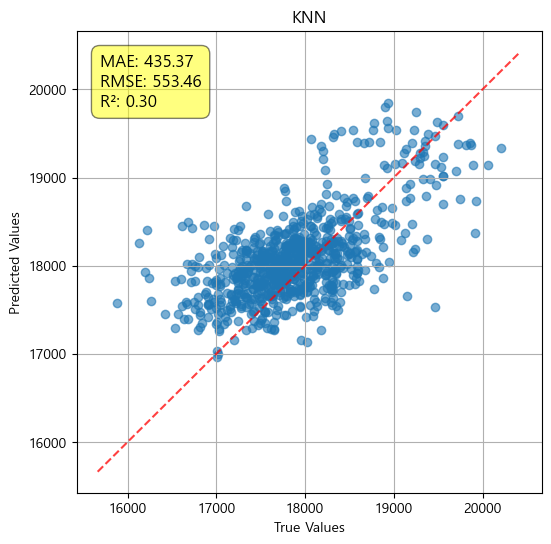

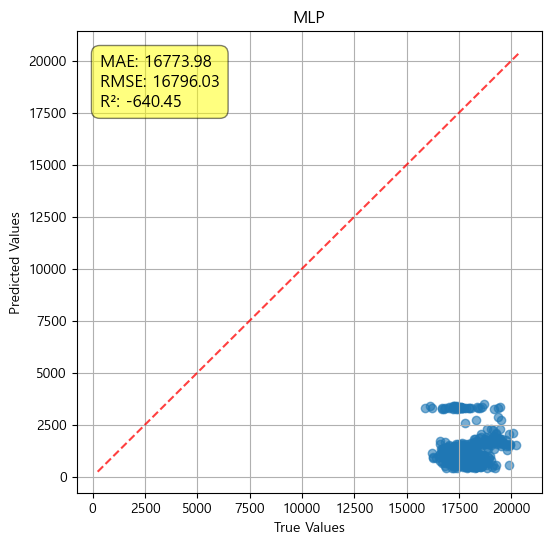

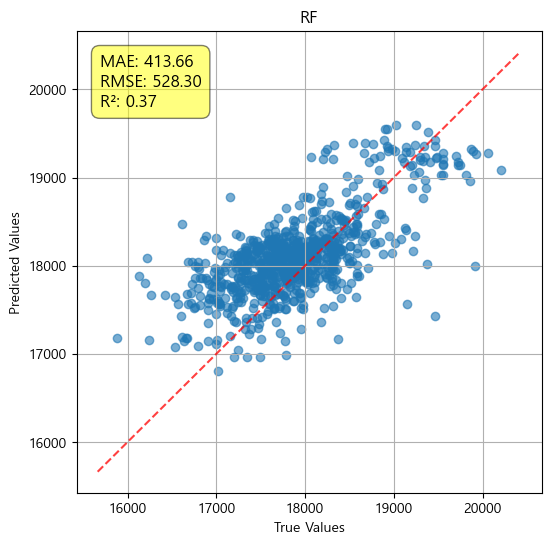

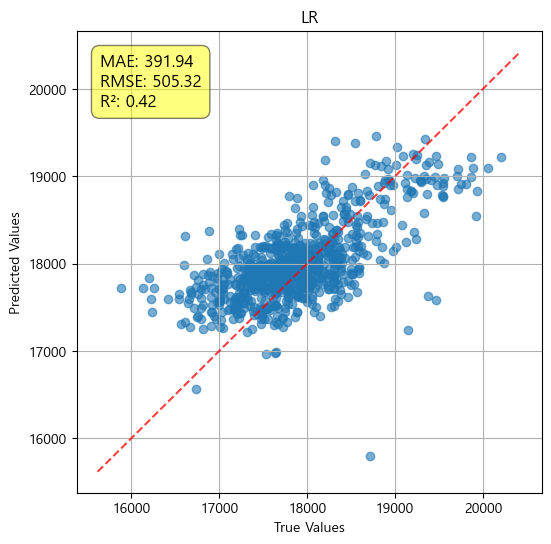

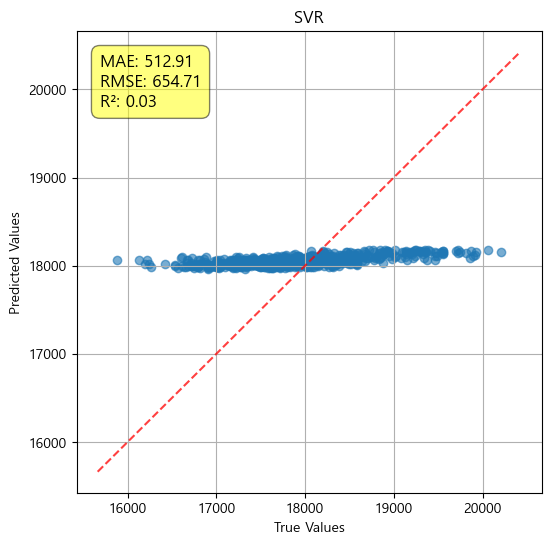

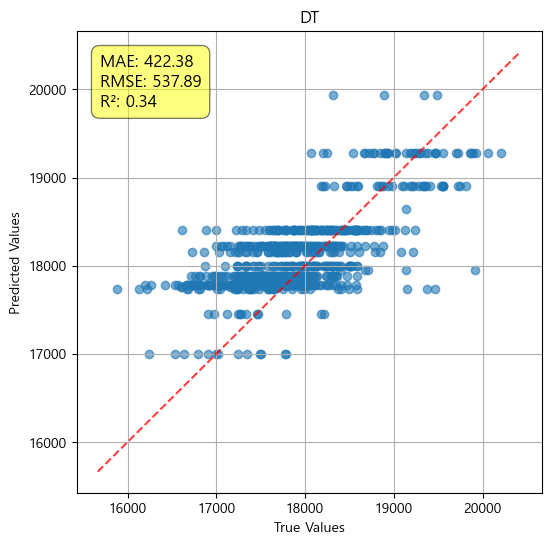

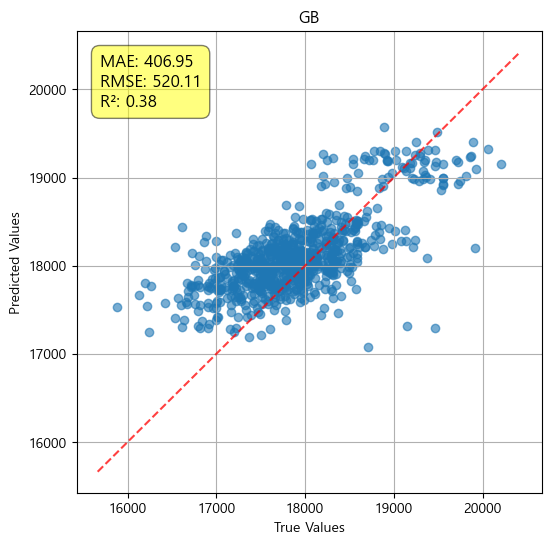

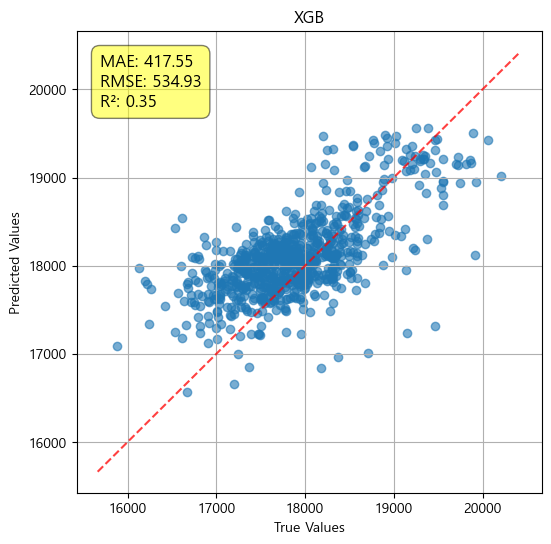

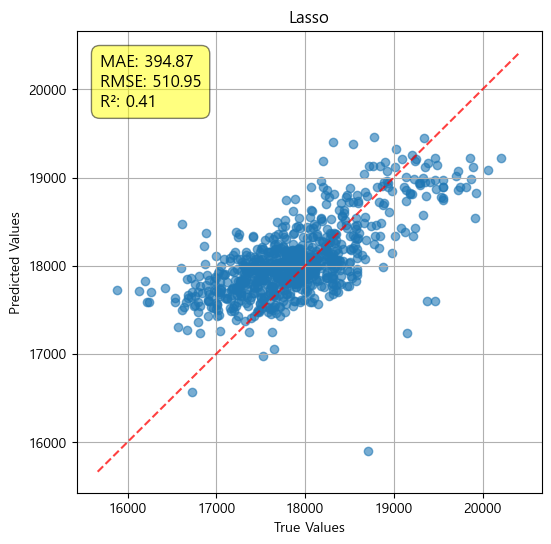

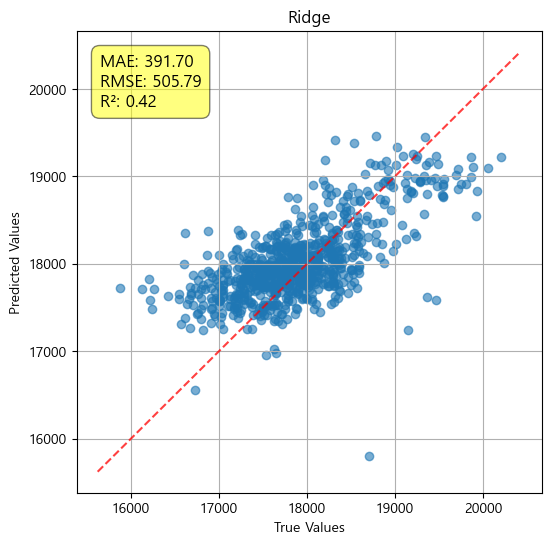

In [213]:
for model_name in models:
    # --- Your existing code ---
    models[model_name].fit(X_train, y_train)

    y_pred_train = models[model_name].predict(X_train)
    y_pred_test = models[model_name].predict(X_test)

    if model_name == 'LR':
        lr_y_test = y_test
        lr_y_pred_test = y_pred_test
        
    # predicts[model_name][0] = y_pred_train
    # predicts[model_name][1] = y_pred_test

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    train_rmse = root_mean_squared_error(y_train, y_pred_train)
    test_rmse = root_mean_squared_error(y_test, y_pred_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f'{model_name} | train MAE: {train_mae:.2f} RMSE: {train_rmse:.2f} R2: {train_r2:.2f} | test MAE: {test_mae:.2f} RMSE: {test_rmse:.2f} R2: {test_r2:.2f}')

    # scatter_plot_mae(y_test, y_pred_test)
    scatter_plot_metric(y_test, y_pred_test, ['mae', 'rmse', 'r2'])
    
    plt.title(model_name)

Text(0.5, 1.0, 'LR')

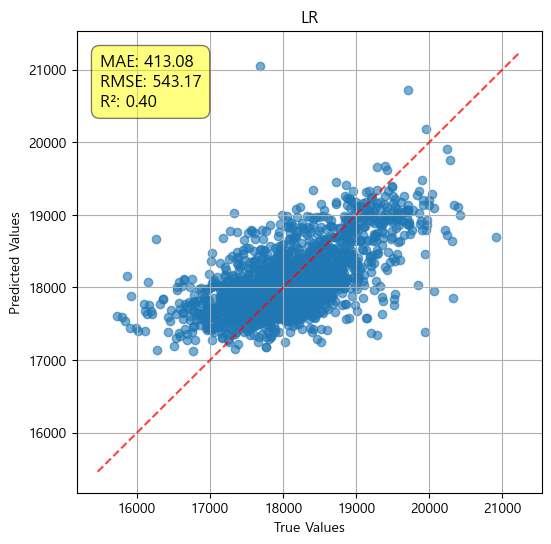

In [214]:
y_pred_train = models['LR'].predict(X_train)

scatter_plot_metric(y_train, y_pred_train, ['mae', 'rmse', 'r2'])
plt.title('LR')

LR train: 413.08 test: 388.79


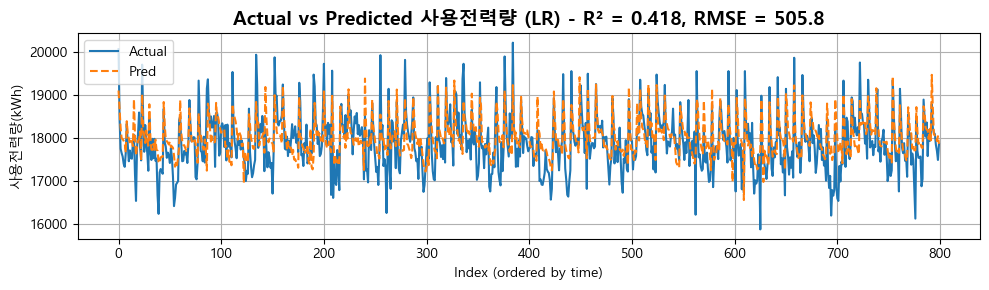

In [ ]:
# --- Your existing code ---
y_pred_train = models['LR'].predict(X_train)
y_pred_test = models['LR'].predict(X_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test_filtered, y_pred_test_filtered)

print(f'LR train: {train_mae:.2f} test: {test_mae:.2f}')

# Plot with vertical lines at restarts
plt.figure(figsize=(10, 3))
plt.plot(range(len(y_test_filtered)), y_test_filtered, color='tab:blue', label='Actual')
plt.plot(range(len(y_pred_test_filtered)), y_pred_test_filtered, color='tab:orange', linestyle='--', label='Pred')

'''
# Insert vertical dashed lines at known restart indices
restart_indices = [66, 200, 311, 534, 728]
for idx in restart_indices:
    if 0 <= idx < len(y_test_filtered):
        plt.axvline(x=idx, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
'''

plt.xlabel('Index (ordered by time)') 
plt.ylabel('사용전력량(kWh)') 
plt.legend() 
plt.title(f'Actual vs Predicted 사용전력량 (LR) - R² = {test_r2:.3f}, RMSE = {test_rmse:.1f}', fontsize=14, fontweight='bold') 
plt.tight_layout() 
plt.grid(True) 
plt.show()


In [216]:
threshold = 16000

# For training predictions
low_indices_train = np.where(y_pred_train < threshold)[0]   # indices
low_values_train = y_pred_train[y_pred_train < threshold]   # values

# For test predictions
low_indices_test = np.where(y_pred_test < threshold)[0]
low_values_test = y_pred_test[y_pred_test < threshold]

print("Train - indices:", low_indices_train)
print("Train - values:", low_values_train)

print("Test - indices:", low_indices_test)
print("Test - values:", low_values_test)

Train - indices: []
Train - values: []
Test - indices: [8]
Test - values: [15799.31846485]



--- SHAP Summary: Linear Regression ---


C:\Users\User\AppData\Local\Temp\ipykernel_20088\742517770.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_lin, X_test, plot_type="bar")


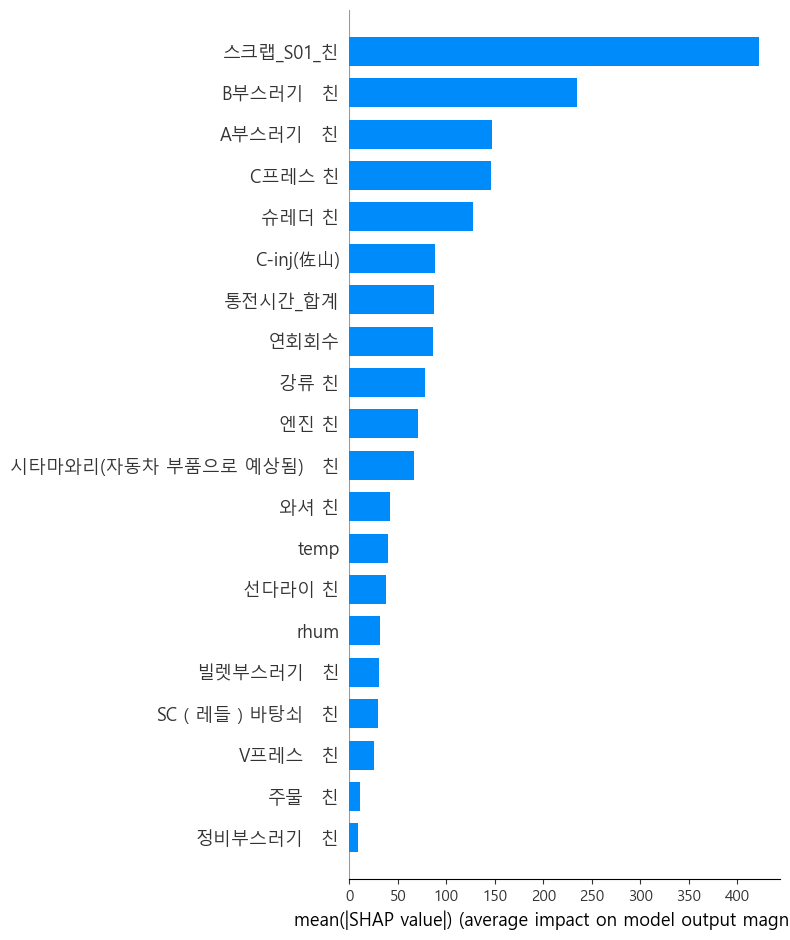

In [217]:
# SHAP for linear model
explainer_lin = shap.Explainer(models['LR'], X_test)
shap_values_lin = explainer_lin(X_test)

# Global importance plot
print("\n--- SHAP Summary: Linear Regression ---")
shap.summary_plot(shap_values_lin, X_test, plot_type="bar")

In [218]:
model = models['LR']     # your trained LinearRegression
X_source = X_train       # or X_test
first_idx, last_idx = 0, len(X_source)-1  # change if you want a specific slice

# --- coefficients/intercept (handle possible 2D shapes safely) ---
coef = np.asarray(model.coef_)
if coef.ndim == 2:
    coef = coef[0]
coef = coef.ravel()
intercept = model.intercept_
if np.ndim(intercept) > 0:
    intercept = float(np.asarray(intercept).ravel()[0])

# --- choose slice of X ---
if hasattr(X_source, "iloc"):
    X_slice = X_source.iloc[first_idx:last_idx+1]
    feature_names = list(X_source.columns)
    data = X_slice.to_numpy()
else:
    X_slice = np.asarray(X_source)[first_idx:last_idx+1]
    data = X_slice
    feature_names = [f"x{i}" for i in range(len(coef))]

# --- sanity check ---
if data.shape[1] != len(coef):
    raise ValueError(
        f"Feature count mismatch: X has {data.shape[1]} columns but model has {len(coef)} coefficients. "
        "If you used preprocessing that expands features (e.g., one-hot), compute metrics on the transformed matrix."
    )

# --- per-row contributions: (n_rows, n_features) ---
contrib = data * coef

# metrics across the selected rows
avg_contribution = contrib.mean(axis=0)                 # keeps sign
abs_avg_contribution = np.abs(avg_contribution)         # abs of the average
mean_abs_contribution = np.abs(contrib).mean(axis=0)    # average absolute magnitude

# optional: average feature value (can help interpret scale)
avg_value = data.mean(axis=0)

# build table
summary_df = pd.DataFrame({
    "Feature": feature_names,

    "mean_abs_contribution": mean_abs_contribution,
})

# print intercept
print("Intercept:", intercept)

# sort by your preferred metric (requested metric: mean_abs_contribution)
summary_sorted = summary_df.sort_values("mean_abs_contribution", ascending=False).reset_index(drop=True)
print(summary_sorted.head(20))

Intercept: 18086.213546566323
                  Feature  mean_abs_contribution
0               스크랩_S01_친             390.033968
1                 B부스러기　친             226.158178
2                  C프레스 친             153.700794
3                   슈레더 친             141.684882
4                 A부스러기　친             133.718340
5                 통전시간_합계              90.130396
6                  선다라이 친              88.850348
7               C-inj(佐山)              85.181264
8                    엔진 친              84.402752
9                    강류 친              82.005949
10  시타마와리(자동차 부품으로 예상됨)　친              78.913959
11                   연회회수              78.261806
12                   와셔 친              65.123096
13                   temp              54.248893
14                   주물　친              40.244416
15               빌렛부스러기　친              36.719451
16                   rhum              26.191474
17                 V프레스　친              24.600819
18               정비부스러기　친              

In [219]:
# Ensure 날짜 is datetime
merged_df['날짜'] = pd.to_datetime(merged_df['날짜'])

start_date = '2024-12-17'
end_date = '2024-12-22'
# middle_date = '2024-12-20'

# Define start and end as full-day datetime range
start_datetime = pd.to_datetime(start_date)
end_datetime = pd.to_datetime(end_date) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

# Create mask
mask = (merged_df['날짜'] >= start_datetime) & (merged_df['날짜'] <= end_datetime)

# Get integer index positions
matching_indices = merged_df.index[mask]

first_idx = matching_indices[0]
last_idx = matching_indices[-1]

print(f"First index: {first_idx}")
print(f"Last index: {last_idx}")

first_idx = first_idx - 2136 + 1
last_idx = last_idx - 2136 + 1
#first_idx = first_idx - 1825 + 1
#last_idx = last_idx - 1825 + 1
print(f"First index: {first_idx}")
print(f"Last index: {last_idx}")

First index: 2839
Last index: 2894
First index: 704
Last index: 759


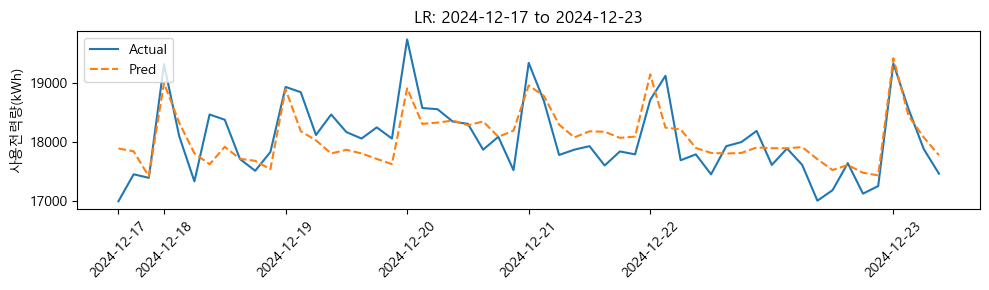

MAE for selected range: 328.063
R² for selected range: 0.576


In [220]:
test_start_idx = first_idx
test_end_idx = (last_idx)

# Slice actual and predicted values
y_test_slice = y_test[test_start_idx:test_end_idx]
y_pred_slice = y_pred_test[test_start_idx:test_end_idx]


# Get the corresponding datetime values for the test set slice
date_series = merged_df.loc[y_test.index[test_start_idx:test_end_idx], '날짜'].reset_index(drop=True)

# Detect points where the date changes
date_change_indices = [0] + [i for i in range(1, len(date_series)) if date_series[i].date() != date_series[i-1].date()]
date_change_labels = [date_series[i].strftime('%Y-%m-%d') for i in date_change_indices]
'''
# Convert middle_date to datetime
middle_datetime = pd.to_datetime(middle_date)

# Find first index in date_series where the date equals middle_date
middle_date_index = date_series[date_series.dt.date == middle_datetime.date()].index[0]

# Compute actual plot index for vertical line
middle_plot_index = test_start_idx + middle_date_index
'''
# Plot
plt.figure(figsize=(10, 3))
plt.plot(range(test_start_idx, test_end_idx), y_test[test_start_idx:test_end_idx], color='tab:blue', label='Actual')
plt.plot(range(test_start_idx, test_end_idx), y_pred_test[test_start_idx:test_end_idx], color='tab:orange', linestyle='--', label='Pred')

#plt.axvline(x=middle_plot_index, color='red', linestyle=':', label=f'{middle_date} 시작')

#plt.xlabel('날짜')
plt.ylabel('사용전력량(kWh)')
plt.title(f'LR: {date_series.iloc[0].date()} to {date_series.iloc[-1].date()}')
plt.legend()

# Apply x-ticks where the date changes

plt.xticks(
    ticks=[test_start_idx + i for i in date_change_indices],
    labels=date_change_labels,
    rotation=45
)

plt.tight_layout()
plt.show()

# Compute metrics
mae = mean_absolute_error(y_test_slice, y_pred_slice)
r2 = r2_score(y_test_slice, y_pred_slice)

print(f"MAE for selected range: {mae:.3f}")
print(f"R² for selected range: {r2:.3f}")

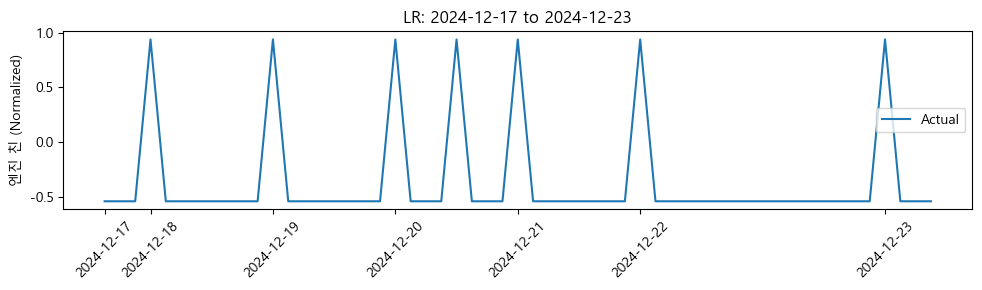

In [221]:
test_start_idx = first_idx
test_end_idx = (last_idx)

# Slice actual and predicted values
y_test_slice = y_test[test_start_idx:test_end_idx]
y_pred_slice = y_pred_test[test_start_idx:test_end_idx]


# Get the corresponding datetime values for the test set slice
date_series = merged_df.loc[y_test.index[test_start_idx:test_end_idx], '날짜'].reset_index(drop=True)

# Detect points where the date changes
date_change_indices = [0] + [i for i in range(1, len(date_series)) if date_series[i].date() != date_series[i-1].date()]
date_change_labels = [date_series[i].strftime('%Y-%m-%d') for i in date_change_indices]
'''
# Convert middle_date to datetime
middle_datetime = pd.to_datetime(middle_date)

# Find first index in date_series where the date equals middle_date
middle_date_index = date_series[date_series.dt.date == middle_datetime.date()].index[0]

# Compute actual plot index for vertical line
middle_plot_index = test_start_idx + middle_date_index
'''
# Plot
plt.figure(figsize=(10, 3))
plt.plot(range(test_start_idx, test_end_idx), X_test[test_start_idx:test_end_idx]['엔진 친'], color='tab:blue', label='Actual')

#plt.axvline(x=middle_plot_index, color='red', linestyle=':', label=f'{middle_date} 시작')

#plt.xlabel('날짜')
plt.ylabel('엔진 친 (Normalized)')
plt.title(f'LR: {date_series.iloc[0].date()} to {date_series.iloc[-1].date()}')
plt.legend()

# Apply x-ticks where the date changes

plt.xticks(
    ticks=[test_start_idx + i for i in date_change_indices],
    labels=date_change_labels,
    rotation=45
)

plt.tight_layout()
plt.show()

In [222]:
print(X_test[test_start_idx:test_end_idx]['캔프레스\u3000자'])

KeyError: '캔프레스\u3000자'

In [ ]:
# Extract the slice and flatten it
predicted_values = y_pred_test[test_start_idx:test_end_idx].flatten()
#actual_values = y_test[test_start_idx:test_end_idx].flatten()

# Create a DataFrame for pretty printing
df_pred = pd.DataFrame({
    'Index': range(test_start_idx, test_end_idx),
    'Predicted Value': predicted_values
    #'Actual Value': actual_values
})

# Display the table
print(df_pred.to_string(index=False))

 Index  Predicted Value
   704     18278.152505
   705     17732.605432
   706     17440.483767
   707     17532.345291
   708     17466.595324
   709     17357.737435
   710     17378.899792
   711     18852.499934
   712     18215.652965
   713     17731.877717
   714     17641.927423
   715     17865.931475
   716     17626.245904
   717     17603.864371
   718     17483.987588
   719     18752.239525
   720     18096.475341
   721     17954.166924
   722     17736.329135
   723     17717.347895
   724     17691.712362
   725     17554.059320
   726     17214.562098
   727     18810.440529
   728     18211.638882
   729     18385.284907
   730     18373.300302
   731     18386.107234
   732     18351.744362
   733     18192.046365
   734     18198.873335
   735     18854.962336
   736     18737.359753
   737     18241.306761
   738     18022.677305
   739     18207.843533
   740     18084.407062
   741     17934.633829
   742     18077.421128
   743     19019.898836
   744     18265

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

def top_feature_impacts_safe(model, X, row_idx=0, top_n=5, target_idx=0):
    """
    Works for plain linear estimators or Pipelines whose final step is linear.
    Returns a sorted DataFrame of per-feature contributions for one row.
    """
    # pick the row as 2-D (so preprocessors accept it), but later ravel to 1-D
    x_row2d = X.iloc[[row_idx]] if hasattr(X, "iloc") else np.asarray(X)[[row_idx]]

    preproc = None
    est = model
    if isinstance(model, Pipeline):
        if len(model.steps) > 1:
            preproc = Pipeline(model.steps[:-1])
        est = model.steps[-1][1]

    # get feature values in the space the estimator sees
    if preproc is not None:
        Xt = preproc.transform(x_row2d)
        if hasattr(Xt, "toarray"):  # sparse -> dense
            Xt = Xt.toarray()
        row = np.asarray(Xt).ravel()  # <-- ensure 1-D
        try:
            feat_names = list(preproc.get_feature_names_out())
        except Exception:
            feat_names = [f"f{i}" for i in range(len(row))]
    else:
        row = (x_row2d.iloc[0].to_numpy() if hasattr(x_row2d, "iloc") else np.asarray(x_row2d[0])).ravel()
        feat_names = list(X.columns) if hasattr(X, "columns") else [f"x{i}" for i in range(len(row))]

    # flatten coefficients/intercept safely (handle multi-target)
    coef = np.asarray(est.coef_)
    if coef.ndim == 2:
        coef = coef[target_idx]
    coef = coef.ravel()

    # length guard
    if len(coef) != len(row):
        raise ValueError(f"Length mismatch: len(coef)={len(coef)} vs len(row)={len(row)}. "
                         "This usually means your preprocessing expands features (e.g., one-hot), "
                         "so make sure you're explaining in the transformed space (as above).")

    contributions = row * coef  # 1-D x 1-D => 1-D
    intercept = est.intercept_
    if np.ndim(intercept) > 0:
        intercept = float(intercept[target_idx])
    else:
        intercept = float(intercept)

    df = pd.DataFrame({
        "feature": feat_names,
        "contribution": contributions
    })
    df["abs_contribution"] = df["contribution"].abs()
    df = df.sort_values("abs_contribution", ascending=False).head(top_n).reset_index(drop=True)

    pred = float(contributions.sum() + intercept)
    return df, pred


# Pipeline:
top_df, pred = top_feature_impacts_safe(linear_regressor, X_test, row_idx=first_idx, top_n=29)
print(f"Prediction: {pred:.3f}")
display(top_df)

Prediction: 18278.153


,feature,contribution,abs_contribution
0,스크랩_S01_친,-490.032708,490.032708
1,B부스러기 자,248.776356,248.776356
2,B부스러기 친,214.382266,214.382266
3,통전시간_합계,211.428816,211.428816
4,빌렛부스러기 친,136.841610,136.841610
5,친단 자,-123.460993,123.460993
6,temp,116.174650,116.174650
7,슈레더 친,107.529539,107.529539
8,스크랩_S01_자,-100.173667,100.173667
9,강류 친,-95.864850,95.864850


In [ ]:
def avg_feature_impacts(model, X, first_idx, last_idx, target_idx=0):
    """
    Compute the average contribution of each feature across rows [first_idx, last_idx].

    Returns a DataFrame with columns:
    ["feature", "avg_value", "coefficient", "avg_contribution", "abs_avg_contribution"]
    """
    preproc = None
    est = model
    if isinstance(model, Pipeline):
        if len(model.steps) > 1:
            preproc = Pipeline(model.steps[:-1])
        est = model.steps[-1][1]

    # Get transformed data (if pipeline)
    X_slice = X.iloc[first_idx:last_idx+1] if hasattr(X, "iloc") else np.asarray(X)[first_idx:last_idx+1]
    if preproc is not None:
        Xt = preproc.transform(X_slice)
        if hasattr(Xt, "toarray"):  # sparse -> dense
            Xt = Xt.toarray()
        try:
            feat_names = list(preproc.get_feature_names_out())
        except Exception:
            feat_names = [f"f{i}" for i in range(Xt.shape[1])]
        data = np.asarray(Xt)
    else:
        feat_names = list(X.columns) if hasattr(X, "columns") else [f"x{i}" for i in range(X.shape[1])]
        data = np.asarray(X_slice)

    coef = np.asarray(est.coef_)
    if coef.ndim == 2:
        coef = coef[target_idx]
    coef = coef.ravel()

    if data.shape[1] != len(coef):
        raise ValueError(f"Mismatch: {data.shape[1]} features vs {len(coef)} coefficients")

    contributions = data * coef  # shape: (n_rows, n_features)
    avg_value = data.mean(axis=0)
    avg_contrib = contributions.mean(axis=0)

    df = pd.DataFrame({
        "feature": feat_names,
        "avg_value": avg_value,
        "coefficient": coef,
        "avg_contribution": avg_contrib,
        "abs_avg_contribution": np.abs(avg_contrib)
    })
    return df.sort_values("abs_avg_contribution", ascending=False).reset_index(drop=True)

avg_df = avg_feature_impacts(models["LR"], X_test, first_idx=first_idx, last_idx=last_idx)
print(f'From {first_idx} to {last_idx}')
display(avg_df.head(40))

From 704 to 759


,feature,avg_value,coefficient,avg_contribution,abs_avg_contribution
0,스크랩_S01_친,-0.127971,2281.518783,-291.968589,291.968589
1,B부스러기 자,0.288957,423.005293,122.230524,122.230524
2,B부스러기 손,0.608768,191.103285,116.337619,116.337619
3,temp,-1.506726,-72.170345,108.740905,108.740905
4,B부스러기 친,0.092080,691.007571,63.627926,63.627926
5,선다라이 친,0.388823,159.787036,62.128915,62.128915
6,스크랩_S01_자,-0.127289,471.218586,-59.981081,59.981081
7,다라이가루 손,-0.360127,145.444892,-52.378588,52.378588
8,엔진 친,-0.355903,119.111335,-42.392071,42.392071
9,친단 손,-0.515842,60.153717,-31.029828,31.029828


In [ ]:
'''
# Plot
restart_counter = X_test['restart_counter']

plt.figure(figsize=(8, 6))
plt.scatter(restart_counter, y_pred_test, alpha=0.7)
plt.xlabel("Restart Counter")
plt.ylabel("Predicted Value (y_pred_test)")
plt.title("Scatter Plot: y_pred_test vs Restart Counter")
plt.grid(True)
plt.tight_layout()
plt.show()
'''

'\n# Plot\nrestart_counter = X_test[\'restart_counter\']\n\nplt.figure(figsize=(8, 6))\nplt.scatter(restart_counter, y_pred_test, alpha=0.7)\nplt.xlabel("Restart Counter")\nplt.ylabel("Predicted Value (y_pred_test)")\nplt.title("Scatter Plot: y_pred_test vs Restart Counter")\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n'

In [ ]:
'''
# Extract restart_counter from X_test
restart_counter = X_test['restart_counter']

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(restart_counter, y_test, alpha=0.7)
plt.xlabel("Restart Counter")
plt.ylabel("Actual Value (y_test)")
plt.title("Scatter Plot: y_test vs Restart Counter")
plt.grid(True)
plt.tight_layout()
plt.show()
'''

'\n# Extract restart_counter from X_test\nrestart_counter = X_test[\'restart_counter\']\n\n# Plot\nplt.figure(figsize=(8, 6))\nplt.scatter(restart_counter, y_test, alpha=0.7)\nplt.xlabel("Restart Counter")\nplt.ylabel("Actual Value (y_test)")\nplt.title("Scatter Plot: y_test vs Restart Counter")\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n'

In [ ]:
# Get indices where y_test < 15000
indices_below_15000 = np.where(y_test < 15000)[0]

# Print the result
print("Indices where y_test < 15000:", indices_below_15000)

Indices where y_test < 15000: [509 510 511 512]


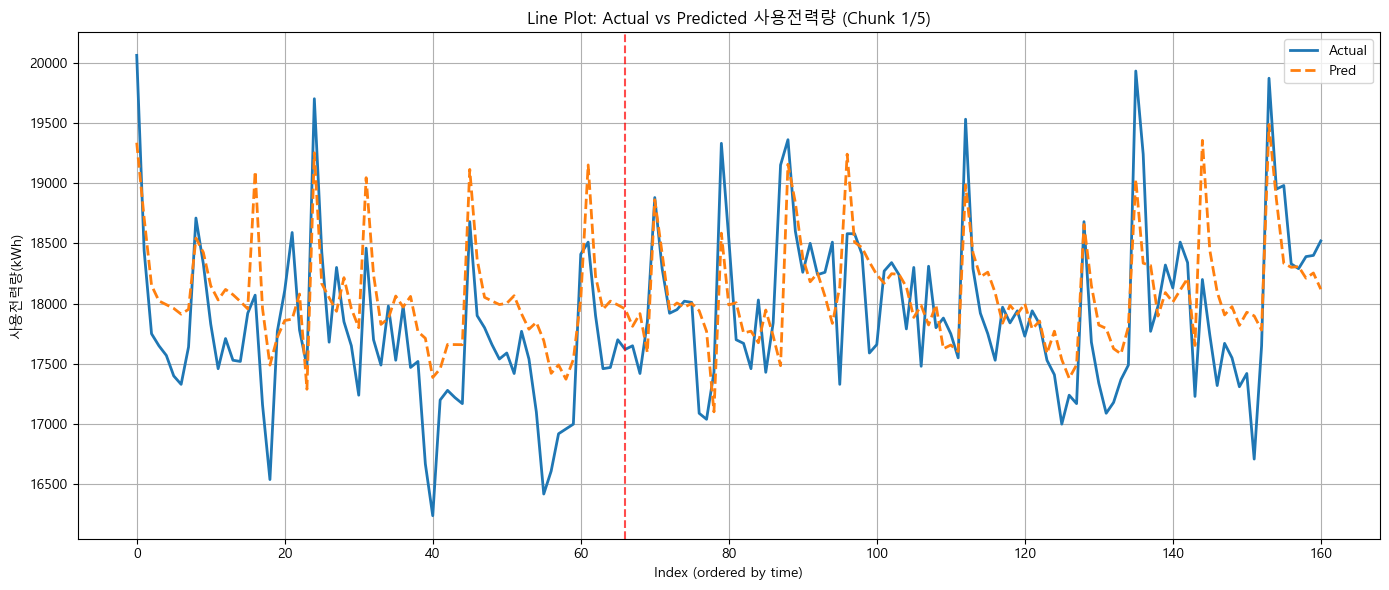

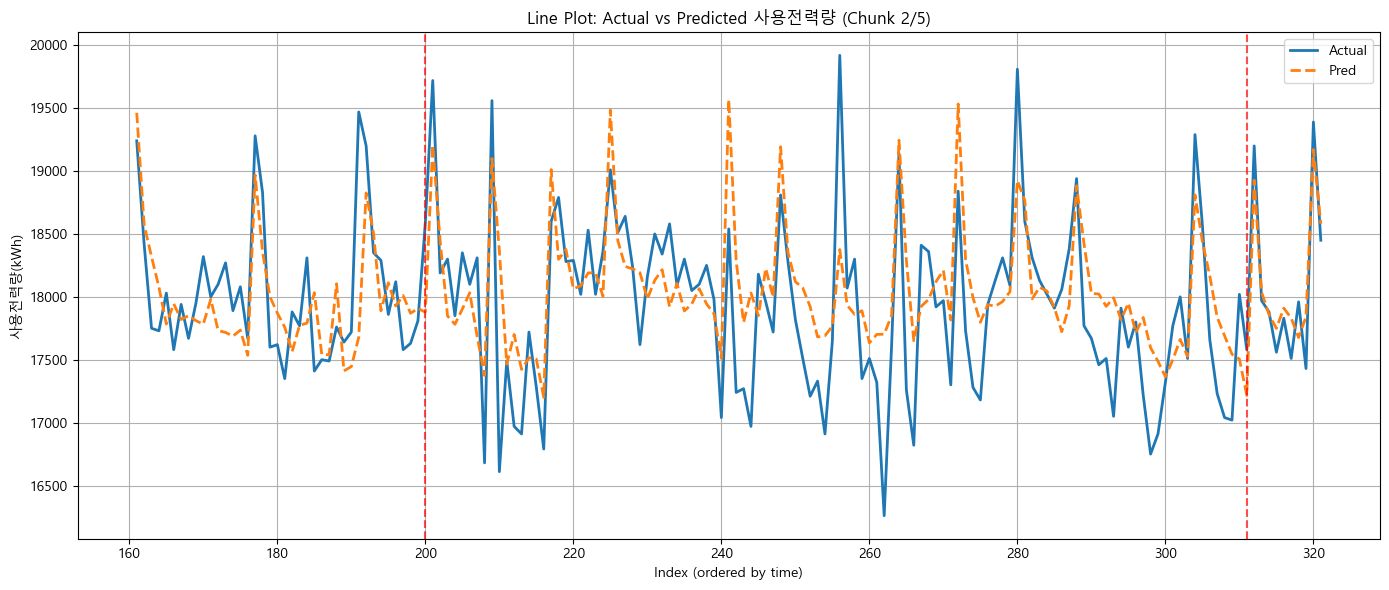

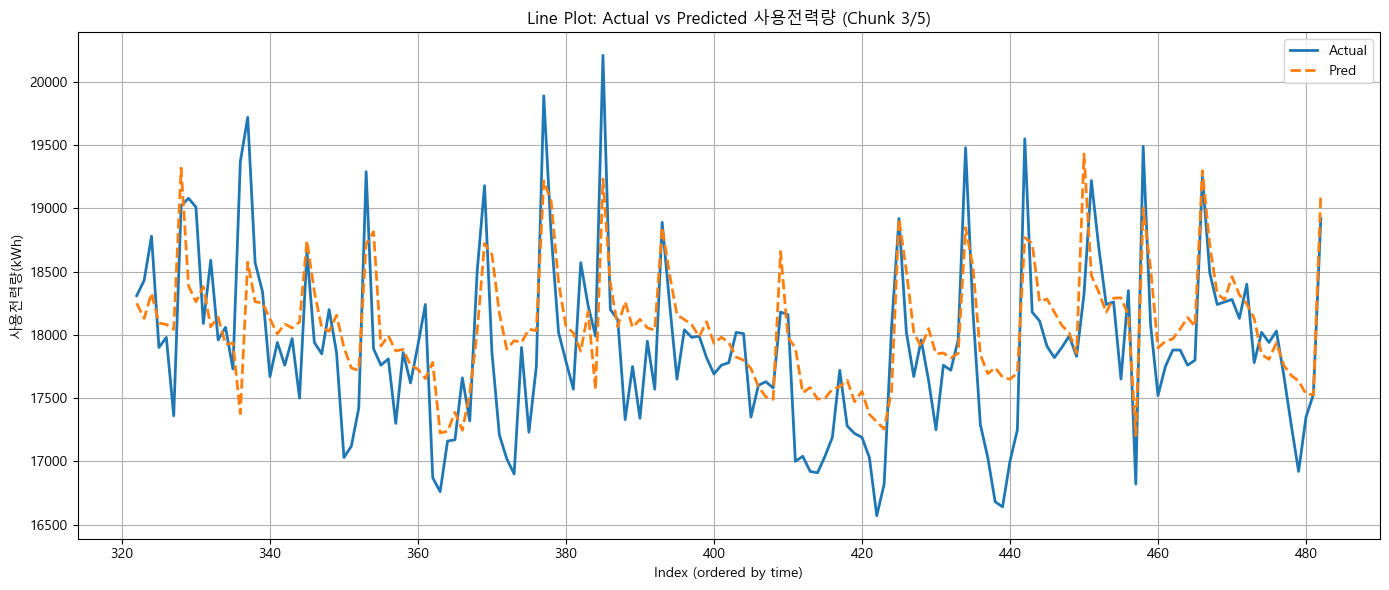

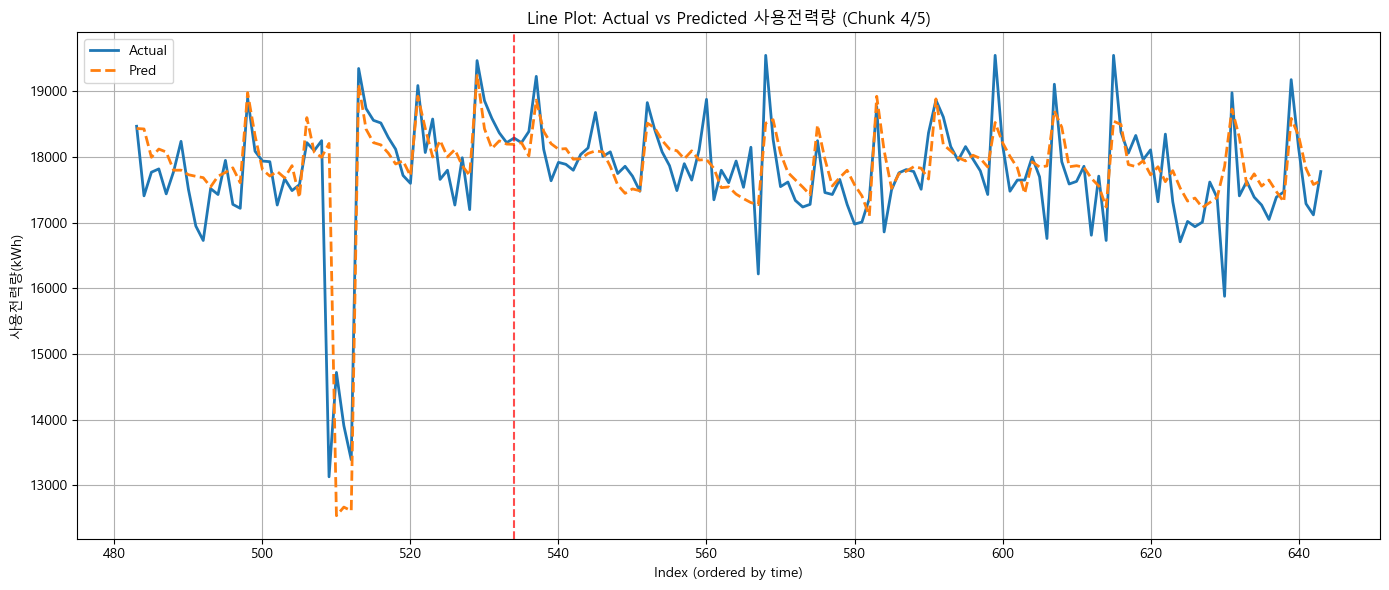

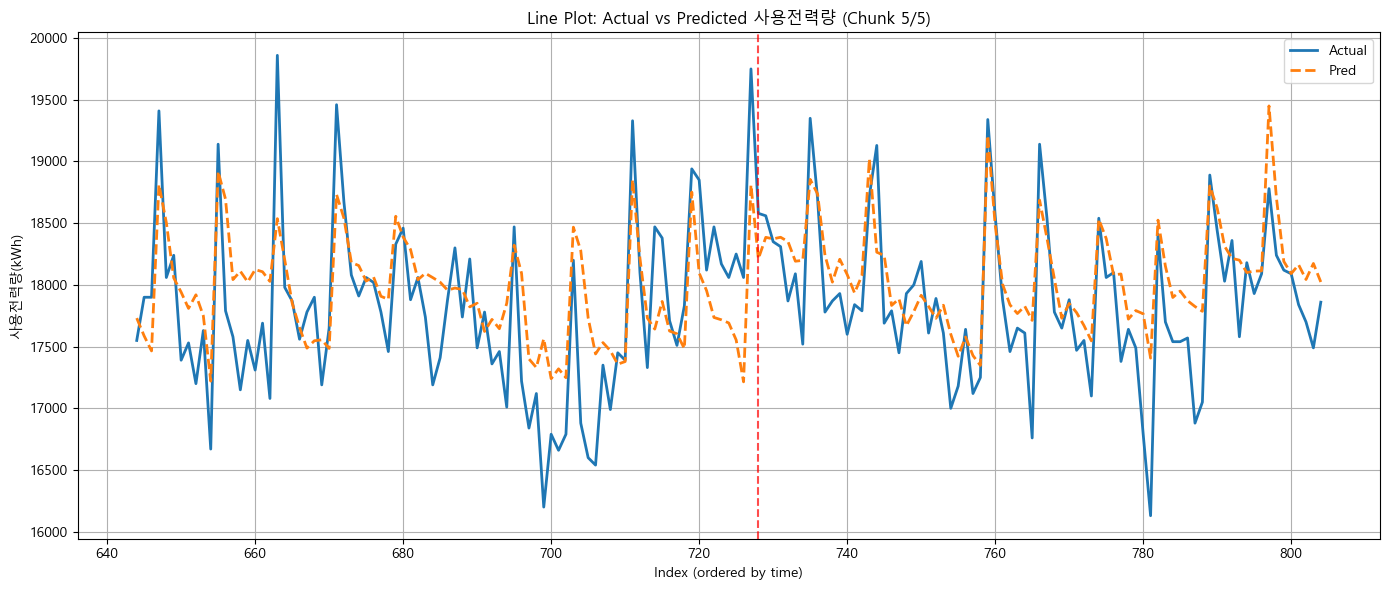

In [ ]:
import matplotlib.pyplot as plt

n = len(y_test)
chunk_size = n // 5
restart_indices = [66, 200, 311, 534, 728]  # your fixed restart points

for i in range(5):
    start = i * chunk_size
    end = (i + 1) * chunk_size if i < 4 else n

    x_range = range(start, end)
    y_chunk = y_test[start:end]
    y_pred_chunk = y_pred_test[start:end]

    plt.figure(figsize=(14, 6))
    plt.plot(x_range, y_chunk, color='tab:blue', label='Actual', linewidth=2)
    plt.plot(x_range, y_pred_chunk, color='tab:orange', linestyle='--', label='Pred', linewidth=2)

    # Draw vertical lines for restart indices if they fall within this chunk
    for idx in restart_indices:
        if start <= idx < end:
            plt.axvline(x=idx, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

    plt.title(f'Line Plot: Actual vs Predicted 사용전력량 (Chunk {i+1}/5)')
    plt.xlabel('Index (ordered by time)')
    plt.ylabel('사용전력량(kWh)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
